In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT as rt
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
import os
import json

Warning in <TInterpreter::ReadRootmapFile>: class  HepMC::FourVector found in libSimDataFormatsGeneratorProducts.so  is already in libHepMC3rootIO.so 


Welcome to JupyROOT 6.28/00


/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/sft.cern.ch/lcg/views/LCG_103/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  r

In [2]:
#import helper modules for muon scale factor computation
sys.path.append("/storage/af/user/aalbert/CMSSW_14_1_0_pre4/src/RazorCommon_correctionslib/RazorCommon/Tools/bin")
import importlib
import getMuonScaleFactor

In [3]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    #events = events[start:stop]
    return events

In [4]:
#paths
MC_paths = {"2022":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer22/DYto2Mu_MLL-50to120_keepMDSHits_Merged/DYto2Mu_MLL-50to120_keepMDSHits_7311pb_weighted.root",
            "2022EE":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer22EE/DYto2Mu_MLL-50to120_keepMDSHits_Merged/DYto2Mu_MLL-50to120_keepMDSHits_26642pb_weighted.root",
            "2023":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer23/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_18411pb_weighted.root",
            "2023BPix":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer23BPix/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_9451pb_weighted.root",
           "2024":"/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/MC_VetoEff/MC_Summer24/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_108753pb_weighted.root"
           }

data_path_lists = {"2022":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022C_PromptReco-v1_goodLumi.root",
                          "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022D_PromptReco-v1_goodLumi.root"],
                 
                   "2022EE":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022E_PromptReco-v1_goodLumi.root",
                          "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022F_PromptReco-v1_goodLumi.root",
                            "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2022_Merged/Muon_Run2022G_PromptReco-v1_goodLumi.root"],
                   
                    "2023":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023B_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023B_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v3_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v3_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023C_PromptReco-v4_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023C_PromptReco-v4_goodLumi.root"],
                  
                      "2023BPix":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023D_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023D_PromptReco-v1_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon0_Run2023D_PromptReco-v2_goodLumi.root",
                     "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2023_Merged/Muon1_Run2023D_PromptReco-v2_goodLumi.root"],
                       
                    "2024":["/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024B-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024C-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024D-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024E-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024E-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024F-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024G-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024H-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024I-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon0-Run2024I-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024B-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024C-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024D-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024E-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024E-PromptReco-v2-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024F-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024G-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024H-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024I-PromptReco-v1-AOD_goodLumi.root",
                    "/storage/af/user/aalbert/CMSSW_10_6_20/src/run3_llp_analyzer/output_nTuples/Data_VetoEff/2024_Merged/Muon1-Run2024I-PromptReco-v2-AOD_goodLumi.root"]
                      
                             }

In [5]:
#events_data = getLZDF(data_path)
events_MC_full_dict= {}
for campaign, MC_path in MC_paths.items():
    if "2022"!=campaign:continue
    print(campaign)
    events_MC_full = getLZDF(MC_path)
    events_MC_full = events_MC_full[np.logical_and(events_MC_full.ZMass>50, events_MC_full.ZMass<120)]
    events_MC_full = events_MC_full[np.logical_and(events_MC_full.Flag_all, events_MC_full.Flag_ecalBadCalibFilter)]
    events_MC_full = events_MC_full[events_MC_full.jetVeto]
    events_MC_full_dict[campaign] = events_MC_full

2022


In [6]:
events_data_full_dict= {}
for campaign, data_path_list in data_path_lists.items():
    if "2022"!=campaign:continue
    print(campaign)
    data_events = [getLZDF(data_path) for data_path in data_path_list]
    events_data_full = ak.concatenate(data_events, axis=0)
    events_data_full = events_data_full[np.logical_and(events_data_full.ZMass>50, events_data_full.ZMass<120)]
    events_data_full = events_data_full[np.logical_and(events_data_full.Flag_all, events_data_full.Flag_ecalBadCalibFilter)]
    events_data_full = events_data_full[events_data_full.jetVeto]
    events_data_full_dict[campaign] = events_data_full

2022


In [19]:
events_data_full_dict["2022"].numMatchedRechits_DT

<Array [0, 0, 0, 2, 0, 0, ... 0, 0, 0, 1, 3, 3] type='5112658 * int32'>

In [7]:
branch_names = ["weight", "ZMass","npv", "pileupWeight","sampledEta","sampledPhi"]

In [8]:
#get low MET weights from signal cluster distributions
lowMET_CSCCSC = rt.TFile.Open("clusterDistributionsForVeto/lowMET/CSCCSC.root","READ")
lowMET_CSCHist = lowMET_CSCCSC.Get("CscClusters0").Clone()
lowMET_CSCHist.SetDirectory(0)
second_CSC = lowMET_CSCCSC.Get("CscClusters1").Clone()
second_CSC.SetDirectory(0)
lowMET_CSCHist.Add(second_CSC)
lowMET_CSCHist.Scale(1/lowMET_CSCHist.GetSumOfWeights())

lowMET_DTCSC = rt.TFile.Open("clusterDistributionsForVeto/lowMET/DTCSC.root","READ")
lowMET_DTHist = lowMET_DTCSC.Get("DtClusters").Clone()
lowMET_DTHist.SetDirectory(0)
totalFactor = lowMET_DTHist.GetSumOfWeights()
lowMET_DTHist.Scale(1/lowMET_DTHist.GetSumOfWeights())


In [9]:
def getSFLoose(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preEE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_EE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preBPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_LooseID, MC_SF_LooseISO

In [10]:
def getSFTight(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preEE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preEE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_EE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_EE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preBPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preBPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_BPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_BPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT

In [11]:
def getSF(campaign, pt, eta):
    if campaign=="2022":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preEE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preEE(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preEE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preEE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preEE(pt, eta)
    elif campaign=="2022EE":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_EE(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_EE(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_EE(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_EE(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_EE(pt, eta)
    elif campaign=="2023":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preBPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preBPix(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preBPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preBPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preBPix(pt, eta)
    elif campaign=="2023BPix" or campaign=="2024":
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(pt, eta)
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_BPix(pt, eta)
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_BPix(pt, eta)
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_BPix(pt, eta)
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_BPix(pt, eta)
    else:
        print("invalid campaign. exiting...")
        exit()
    return MC_SF_LooseID, MC_SF_LooseISO, MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT

In [12]:
MC_kFactors = {"2022":0.9202108866645403,"2022EE":0.9205275233052539,"2023":0.9287192347533128,"2023BPix":0.938125553192627,"2024":0.9070469152942339}

In [13]:
def getBranches(LZDF, campagin, isMC=False):
    print("adding generic branches")
    new_df = ak.zip({field:LZDF[field]  for field in branch_names})
    
    #new_df = ak.zip({field: np.repeat(LZDF[field], LZDF["numTag"]) for field in branch_names})
#     for branch in branch_names:
#         if (not isMC) and (branch in ["weight", "pileupWeight"]):
#             continue
#         new_df = ak.with_field(new_df, np.repeat(LZDF[branch],LZDF["numTag"]), branch)
    #print("finished event level variables")
#     totalSize = ak.size(LZDF_big.ZMass)
#     print(type(totalSize))
#     chunkSize = totalSize // 10
#     print(chunkSize)
#     print(type(chunkSize))
#     df_list = []
#     for i in range(0, totalSize, chunkSize):
#         print("Processing Chunk ",i)
#         initial_mask = np.array([False]*totalSize)
#         initial_mask[i:i+chunkSize] = True
#         LZDF = LZDF_big[initial_mask]
#         print(ak.count_nonzero(LZDF.weight))
    lepTag_array = LZDF["lepTag"]
    lepTag_array = np.repeat(lepTag_array,np.array(LZDF["numTag"]), axis=0)
    arr = np.zeros(np.shape(lepTag_array)[0], dtype=bool)
    arr[::2] = 1  # Set even indices to 1
    mask = ak.all(lepTag_array, axis=1)
    mask_T_F = np.logical_and(arr, mask)
    mask_F_T = np.logical_and(np.logical_not(arr), mask)
    lepTag_array = np.array(lepTag_array)
    lepTag_array.reshape((np.array(mask_T_F).shape[0],2))
    lepTag_array[mask_T_F] = [True, False]
    lepTag_array[mask_F_T] = [False, True]

    row_indices = np.arange(lepTag_array.shape[0], dtype=int)
    column_indices_probe =np.where(lepTag_array==False)[1]
    column_indices_tag =np.where(lepTag_array==True)[1]

    #lowMET CSC first
    print("computing low MET CSC weighting")
    lowMET_CSCWeights = ak.Array([0]*ak.count_nonzero(new_df.ZMass))
    for binNum in range(lowMET_CSCHist.GetNbinsX()):
        leftEdge = lowMET_CSCHist.GetBinLowEdge(binNum)
        rightEdge = leftEdge + lowMET_CSCHist.GetBinWidth(binNum)
        lowMET_CSCWeights = ak.where(np.logical_and(np.abs(new_df.sampledEta)>=leftEdge, np.abs(new_df.sampledEta)<rightEdge),lowMET_CSCHist.GetBinContent(binNum), lowMET_CSCWeights)
    new_df = ak.with_field(new_df,lowMET_CSCWeights, "lowMET_CSCWeights")
    
    lowMET_DTWeights = ak.Array([0]*ak.count_nonzero(new_df.ZMass))
    print("computing low MET DT weighting")
    for binNum in range(lowMET_DTHist.GetNbinsX()):
        leftEdge = lowMET_DTHist.GetBinLowEdge(binNum)
        rightEdge = leftEdge + lowMET_DTHist.GetBinWidth(binNum)
        lowMET_DTWeights = ak.where(np.logical_and(np.abs(new_df.sampledEta)>=leftEdge, np.abs(new_df.sampledEta)<rightEdge),lowMET_DTHist.GetBinContent(binNum), lowMET_DTWeights)
    new_df = ak.with_field(new_df,lowMET_DTWeights, "lowMET_DTWeights")
    
    
    
    
    if isMC:
        MC_SF_LooseID, MC_SF_LooseISO, MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT = getSF(campaign, np.array(LZDF.lepPt), np.array(LZDF.lepEta))

        MC_SF_LooseID = np.repeat(MC_SF_LooseID,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_LooseISO = np.repeat(np.array(MC_SF_LooseISO),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_TightID = np.repeat(MC_SF_TightID,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_TightISO = np.repeat(MC_SF_TightISO,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_HLT = np.repeat(MC_SF_HLT,np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]

        MC_Weight_Total = new_df.weight*MC_SF_LooseID*MC_SF_LooseISO*MC_SF_TightID*MC_SF_TightISO*MC_SF_HLT*new_df.pileupWeight*MC_kFactors[campaign]
        #MC_Weight_Total = MC_Weight_Total*0.9287192347533128 #k-factor to grab 2023 plot, comment out!!!!
        new_df = ak.with_field(new_df, MC_Weight_Total, "weight_total")

        
        
    
        
        
    
    
        
        
        
        #         LZDF_onetag = LZDF[LZDF.numTag==1]
#         LZDF_twotag = LZDF[LZDF.numTag==2]
        
#         #LZDF_onetag_probe = LZDF_onetag[LZDF_onetag.lepTag==False]
#         #LZDF_onetag_tag = LZDF_onetag[LZDF_onetag.lepTag]
#         print("computing one tag SFs")
#         MC_SF_LooseID, MC_SF_LooseISO = getSFLoose(campaign, np.array(ak.flatten(LZDF_onetag.lepPt[LZDF_onetag.lepTag==False])), np.array(ak.flatten(LZDF_onetag.lepEta[LZDF_onetag.lepTag==False])))
#         print("computed loose SFs")
#         MC_SF_TightID, MC_SF_TightISO, MC_SF_HLT = getSFTight(campaign, np.array(ak.flatten(LZDF_onetag.lepPt[LZDF_onetag.lepTag])), np.array(ak.flatten(LZDF_onetag.lepEta[LZDF_onetag.lepTag])))
#         print("computed tight SFs")
#         MC_Weight_Total = LZDF_onetag.weight*MC_SF_LooseID*MC_SF_LooseISO*MC_SF_TightID*MC_SF_TightISO*MC_SF_HLT*LZDF_onetag.pileupWeight
#         print("computed total SF")
#         LZDF_onetag = ak.with_field(LZDF_onetag, MC_Weight_Total, "weight_total")
        
#         #for two tag case, compute 1-P(muon 1 fails loose criteria)-P(muon 2 fails loose criteria)-P(both muons fail tight criteria)
#         arr = np.zeros(np.shape(LZDF_twotag.lepTag),dtype=bool)
#         arr[:,0] = 1
#         print("computing two tag SFs")
#         Muon0_LooseID, Muon0_LooseISO = getSFLoose(campaign, np.array(LZDF_twotag.lepPt[arr]), np.array(LZDF_twotag.lepEta[arr]))
#         Muon1_LooseID, Muon1_LooseISO = getSFLoose(campaign, np.array(LZDF_twotag.lepPt[np.logical_not(arr)]), np.array(LZDF_twotag.lepEta[np.logical_not(arr)]))
        
#         Muon0_TightID, Muon0_TightISO, Muon0_SF_HLT = getSFTight(campaign, np.array(LZDF_twotag.lepPt[arr]), np.array(LZDF_twotag.lepEta[arr]))
#         Muon1_TightID, Muon1_TightISO, Muon1_SF_HLT = getSFTight(campaign, np.array(LZDF_twotag.lepPt[np.logical_not(arr)]), np.array(LZDF_twotag.lepEta[np.logical_not(arr)]))
        
#         print("computed individual SFs")
#         SF_Weight = 1 - (1-Muon0_LooseID*Muon0_LooseISO) - (1-Muon1_LooseID*Muon1_LooseISO) - (1-(1-Muon0_TightID*Muon0_TightISO*Muon0_SF_HLT)*(1-Muon1_TightID*Muon1_TightISO*Muon1_SF_HLT))
        
#         print("computed newSF weight")
#         MC_Weight_Total = LZDF_twotag.weight*SF_Weight*LZDF_twotag.pileupWeight
#         LZDF_twotag = ak.with_field(LZDF_twotag, MC_Weight_Total, "weight_total")
        
#         print("concatenating")
#         LZDF = ak.concatenate([LZDF_onetag, LZDF_twotag])
        
#         #compute SFs for "pileup" muons (DT ones require looseID)
        
#         print("computing pileupmuon SFs")
#         PileupMuon_DT_lowMET_LooseID = getSFLoose(campaign, LZDF.matchedMuonPt_DT_lowMET,matchedMuonEta_DT_lowMET)[0]
#         PileupMuon_DT_highMET_LooseID = getSFLoose(campaign, LZDF.matchedMuonPt_DT_highMET,matchedMuonEta_DT_highMET)[0]
        

    #print("at muon variables")
    
#     if isMC: 
#         new_df = ak.with_field(new_df, LZDF.weight_total, "weight_total")
        #new_df = ak.with_field(new_df, PileupMuon_DT_lowMET_LooseID, "DT_lowMET_SF_LooseID")
        #new_df = ak.with_field(new_df, PileupMuon_DT_highET_LooseID, "DT_highMET_SF_LooseID")
    
    print("adding veto branches")
    new_df = ak.with_field(new_df, LZDF.sampledCSC, "sampledCSC")
    new_df = ak.with_field(new_df, LZDF.sampledDT, "sampledDT")
    
    new_df = ak.with_field(new_df, LZDF.numMatchedJets_CSC==0, "passJetVeto_CSC")
    new_df = ak.with_field(new_df, LZDF.numMatchedJets_DT==0, "passJetVeto_DT")
    
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_CSC==0, "passMuonVeto_CSC")
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_DT_lowMET==0, "passMuonVeto_DT_lowMET")
#     new_df = ak.with_field(new_df, LZDF.numMatchedMuons_DT_highMET==0, "passMuonVeto_DT_highMET")
    
    new_df = ak.with_field(new_df, LZDF.numMatchedRechits_CSC==0, "passRechitVeto_CSC")
    new_df = ak.with_field(new_df, LZDF.numMatchedRechits_DT==0, "passRechitVeto_DT")
    
    
    
    
#     #load pT, eta, and phi for tag and probe muons
#     probe_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
#     probe_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]
#     probe_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_probe]

#     tag_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
#     tag_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]
#     tag_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["numTag"]), axis=0)[row_indices,column_indices_tag]

#     new_df = ak.with_field(new_df, probe_pT, "probe_pT")
#     new_df = ak.with_field(new_df, probe_eta, "probe_eta")
#     new_df = ak.with_field(new_df, probe_phi, "probe_phi")

#     new_df = ak.with_field(new_df, tag_pT, "tag_pT")
#     new_df = ak.with_field(new_df, tag_eta, "tag_eta")
#     new_df = ak.with_field(new_df, tag_phi, "tag_phi")
    #df_list.append(new_df)
    #new_df_big = ak.concatenate(df_list) 
    return new_df

In [14]:
events_MC_dict = {}; events_data_dict={}
for campaign in list(events_data_full_dict.keys()):
    if campaign!="2022":continue
    print(campaign)
    print("MC")
    events_MC = getBranches(events_MC_full_dict[campaign], campaign, True)
    print("now data")
    events_data = getBranches(events_data_full_dict[campaign], campaign, False)
    events_MC_dict[campaign] = events_MC
    events_data_dict[campaign] = events_data

2022
MC
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches
now data
adding generic branches
computing low MET CSC weighting
computing low MET DT weighting
adding veto branches


In [17]:
events_data = events_data_dict["2022"]
events_data[np.logical_and(np.logical_not(events_data.sampledDT),np.logical_not(events_data.passRechitVeto_DT))]

<Array [] type='0 * {"weight": float32, "ZMass": float32, "npv": uint32, "pileup...'>

In [ ]:
events_data

2022
5112658
5112658
data eff:  0.7745022256524884  - 0.0001849758111248656  +  0.00018486837287801094
MC eff:  0.9364722687011268  - 0.0011204105931060804  +  0.0011024517262426814


Warning in <TFile::Append>: Replacing existing TH1: Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Data_num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: MC (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: MC_num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: Rechit_Veto_DT
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals

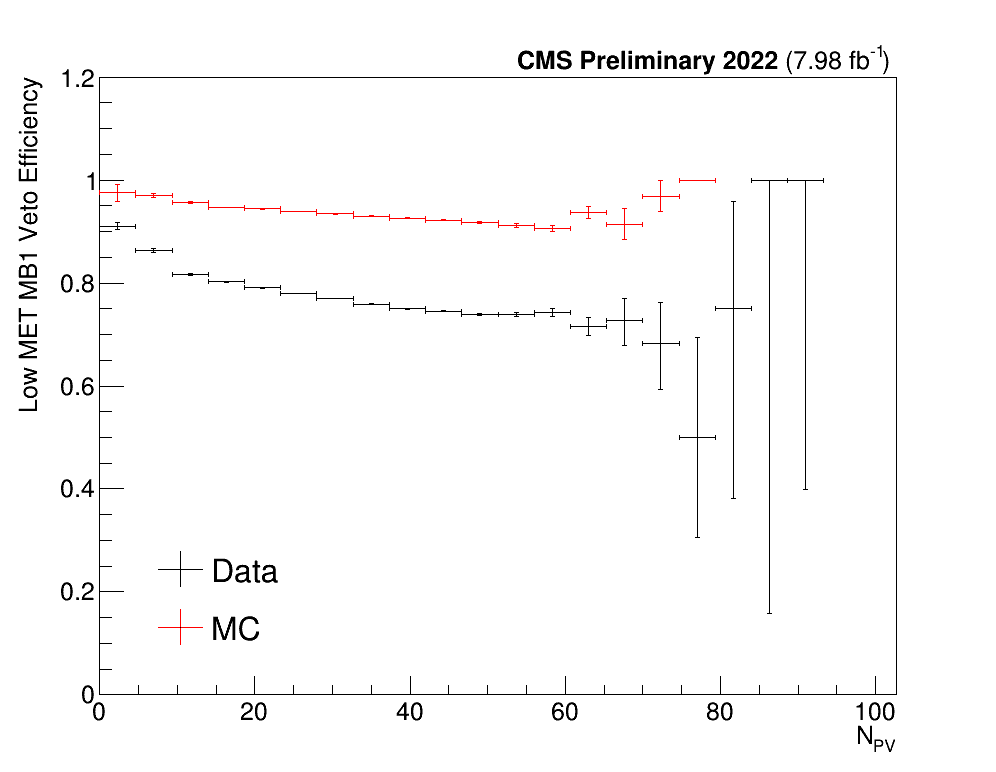

In [64]:
#make histograms

#rechit veto

for campaign in list(events_data_dict.keys()):
    
    
    print(campaign)
    #os.makedirs(dirNameRechitVeto+"/"+campaign, exist_ok=True)
    
    
    nbins, lowBin, highBin = 30, 0, 140


    data_tree = events_data_dict[campaign]
    print(ak.count_nonzero(data_tree.ZMass))
    #data_tree = data_tree[data_tree.sampledDT]
    print(ak.count_nonzero(data_tree.ZMass))

    MC_tree = events_MC_dict[campaign]
    MC_tree = MC_tree[MC_tree.sampledDT]

    #initialize data and MC histograms
    data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
    data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


    hist_info = {}

    #build data hist
    data_arr = np.array(data_tree["npv"], dtype=np.float64)
    data_size = np.size(data_arr)
    #data_weights = np.array(data_tree.lowMET_DTWeights)
    data_weights = np.ones(data_size, dtype=np.float64)
    data.FillN(data_size, data_arr, data_weights)
    data.SetLineColor(rt.kBlack)
    data.SetFillStyle(0)

    data_arr = np.array(data_tree["npv"][data_tree.passRechitVeto_DT], dtype=np.float64)
    data_size = np.size(data_arr)
    #data_weights = np.array(data_tree[data_tree.passRechitVeto_DT].lowMET_DTWeights)
    data_weights = np.ones(data_size, dtype=np.float64)
    data_num.FillN(data_size, data_arr, data_weights)
    data_num.SetLineColor(rt.kBlack)
    data_num.SetFillStyle(0)

    data_eff = rt.TEfficiency(data_num, data)
    data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
    data_eff.SetLineColor(rt.kBlack)
    data_eff.SetTitle(";N_{PV};Low MET MB1 Veto Efficiency")
    
    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,data_num.GetSumOfWeights())
    denom.SetBinContent(1,data.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)
    data_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("data eff: ", data_eff_val.GetEfficiency(1), " -", data_eff_val.GetEfficiencyErrorLow(1), " + ", data_eff_val.GetEfficiencyErrorUp(1))
    

    #build MC hist
    MC_arr = np.array(MC_tree["npv"], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"]*MC_tree["lowMET_DTWeights"])
    MC.FillN(MC_size, MC_arr, MC_weights)
    MC.SetLineColor(rt.kRed)
    MC.SetFillStyle(0)



    MC_arr = np.array(MC_tree["npv"][MC_tree.passRechitVeto_DT], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"][MC_tree.passRechitVeto_DT]*MC_tree["lowMET_DTWeights"][MC_tree.passRechitVeto_DT])
    MC_num.FillN(MC_size, MC_arr, MC_weights)
    MC_num.SetLineColor(rt.kRed)
    MC_num.SetFillStyle(0)

    MC_eff = rt.TEfficiency(MC_num, MC)
    MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
    MC_eff.SetLineColor(rt.kRed)

    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,MC_num.GetSumOfWeights())
    denom.SetBinContent(1,MC.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)  
    MC_eff_val = rt.TEfficiency(num, denom)
    MC_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("MC eff: ", MC_eff_val.GetEfficiency(1), " -", MC_eff_val.GetEfficiencyErrorLow(1), " + ", MC_eff_val.GetEfficiencyErrorUp(1))
    
    C = rt.TCanvas("Rechit_Veto_DT", "Rechit Veto DT", 1000, 800)
    leg = rt.TLegend(0.15, 0.3, 0.4, 0.15)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    data_eff.Draw("E1")
    MC_eff.Draw("E1 SAME")
    C.Update()
    leg.AddEntry(data_eff, "Data", "lep")
    leg.AddEntry(MC_eff, "MC", "lep")
    leg.Draw("SAME")
    #C.Title()
    C.Draw()
    data_eff.GetPaintedGraph().GetYaxis().SetRangeUser(0,1.2)
    cmsText = rt.TLatex()
    cmsText.SetNDC(True)
    cmsText.SetTextFont(42)
    cmsText.SetTextSize(0.035)
    cmsText.SetTextAlign(11)
    if campaign=="2022":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (7.98 fb^{-1})")
    if campaign=="2022EE":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (26.67 fb^{-1})")
    if campaign=="2023":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (18.41 fb^{-1})")
    if campaign=="2023BPix":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (9.45 fb^{-1})")
    if campaign=="2024":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2024} (109.08 fb^{-1})")
    if campaign=="all":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022, 2023, and 2024} (171.59 fb^{-1})")
#     C.SaveAs(dirNameRechitVeto+"/"+campaign+"/RechitVetoPlot.png")
#     file = rt.TFile(dirNameRechitVeto+"/"+campaign+"/RechitVetoPlot.root", "RECREATE")
#     #file.cd()
#     C.Write()
#     data.Write("Data_denom")
#     data_num.Write("Data_num")
#     data_eff.Write("Data_eff")
#     MC.Write("MC_denom")
#     MC_num.Write("MC_num")
#     MC_eff.Write("MC_eff")
#     file.Close()

In [62]:
data_tree = events_data_dict[campaign]
print(ak.count_nonzero(data_tree.ZMass[data_tree.sampledCSC&data_tree.passRechitVeto_DT]))
print(ak.count_nonzero(data_tree.ZMass[data_tree.sampledCSC]))
print(ak.count_nonzero(data_tree.ZMass[data_tree.sampledDT&data_tree.passRechitVeto_DT]))
print(ak.count_nonzero(data_tree.ZMass[data_tree.sampledDT]))

2892320
3194895
1180944
2333837


2022
data eff:  0.5634943301992129  - 0.0022055044987290273  +  0.0022030071464850254
MC eff:  0.9364733072451406  - 0.0011203993172981264  +  0.0011024404984067981


Warning in <TFile::Append>: Replacing existing TH1: Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Data_num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: MC (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: MC_num (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TFile::Append>: Replacing existing TH1: num (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: denom (Potential 

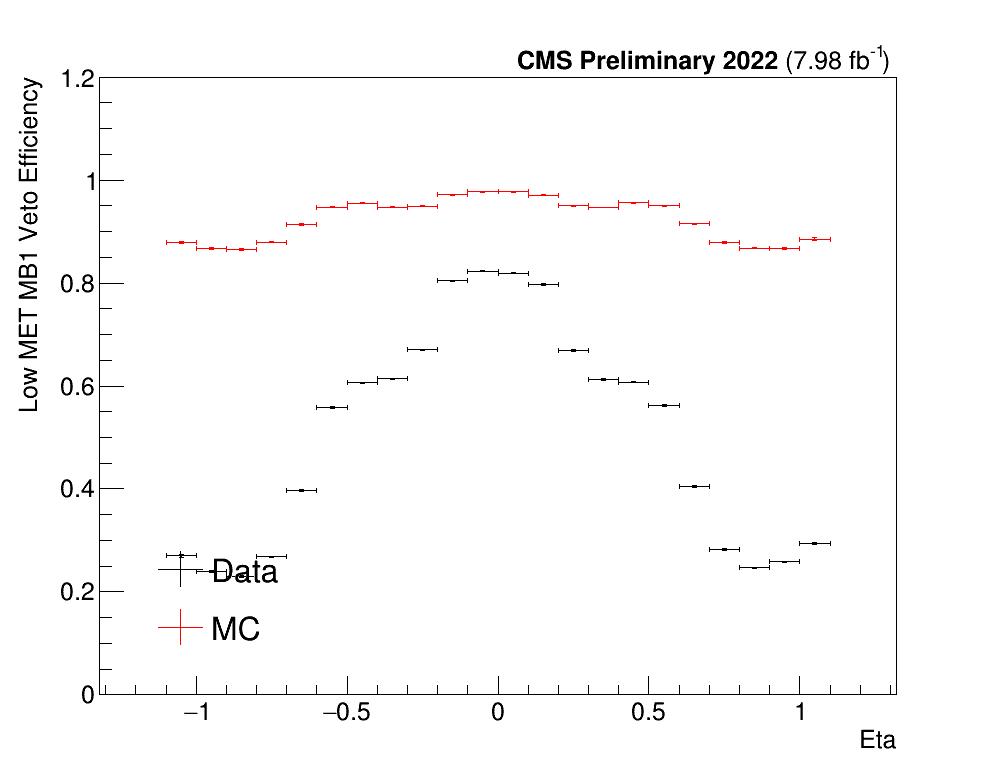

In [35]:
#make histograms

#rechit veto

for campaign in list(events_data_dict.keys()):
    
    
    print(campaign)
    #os.makedirs(dirNameRechitVeto+"/"+campaign, exist_ok=True)
    
    
    nbins, lowBin, highBin = 30, -1.5, 1.5


    data_tree = events_data_dict[campaign]
    data_tree = data_tree[data_tree.sampledDT]

    MC_tree = events_MC_dict[campaign]
    MC_tree = MC_tree[MC_tree.sampledDT]

    #initialize data and MC histograms
    data = rt.TH1F("Data", "Data", nbinsx=nbins, xlow = lowBin, xup=highBin)
    data_num = rt.TH1F("Data_num", "Data_num", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC = rt.TH1F("MC", "MC", nbinsx=nbins, xlow = lowBin, xup=highBin)
    MC_num = rt.TH1F("MC_num", "MC_num", nbinsx=nbins, xlow = lowBin, xup=highBin)


    hist_info = {}

    #build data hist
    data_arr = np.array(data_tree["sampledEta"], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree.lowMET_DTWeights)
    data.FillN(data_size, data_arr, data_weights)
    data.SetLineColor(rt.kBlack)
    data.SetFillStyle(0)

    data_arr = np.array(data_tree["sampledEta"][data_tree.passRechitVeto_DT], dtype=np.float64)
    data_size = np.size(data_arr)
    data_weights = np.array(data_tree[data_tree.passRechitVeto_DT].lowMET_DTWeights)
    data_num.FillN(data_size, data_arr,data_weights)
    data_num.SetLineColor(rt.kBlack)
    data_num.SetFillStyle(0)

    data_eff = rt.TEfficiency(data_num, data)
    data_eff.SetStatisticOption(rt.TEfficiency.kFCP)
    data_eff.SetLineColor(rt.kBlack)
    data_eff.SetTitle(";Eta;Low MET MB1 Veto Efficiency")
    
    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,data_num.GetSumOfWeights())
    denom.SetBinContent(1,data.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)
    data_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("data eff: ", data_eff_val.GetEfficiency(1), " -", data_eff_val.GetEfficiencyErrorLow(1), " + ", data_eff_val.GetEfficiencyErrorUp(1))
    

    #build MC hist
    MC_arr = np.array(MC_tree["sampledEta"], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"]*MC_tree["lowMET_DTWeights"])
    MC.FillN(MC_size, MC_arr, MC_weights)
    MC.SetLineColor(rt.kRed)
    MC.SetFillStyle(0)



    MC_arr = np.array(MC_tree["sampledEta"][MC_tree.passRechitVeto_DT], dtype=np.float64)
    MC_size = np.size(MC_arr)
    MC_weights = np.array(MC_tree["weight_total"][MC_tree.passRechitVeto_DT]*MC_tree["lowMET_DTWeights"][MC_tree.passRechitVeto_DT])
    MC_num.FillN(MC_size, MC_arr, MC_weights)
    MC_num.SetLineColor(rt.kRed)
    MC_num.SetFillStyle(0)

    MC_eff = rt.TEfficiency(MC_num, MC)
    MC_eff.SetStatisticOption(rt.TEfficiency.kFCP) 
    MC_eff.SetLineColor(rt.kRed)

    num = rt.TH1D("num","num",1,0,1)
    denom = rt.TH1D("denom","denom",1,0,1)
    num.SetBinContent(1,MC_num.GetSumOfWeights())
    denom.SetBinContent(1,MC.GetSumOfWeights())
    data_eff_val = rt.TEfficiency(num, denom)  
    MC_eff_val = rt.TEfficiency(num, denom)
    MC_eff_val.SetStatisticOption(rt.TEfficiency.kFCP)
    print("MC eff: ", MC_eff_val.GetEfficiency(1), " -", MC_eff_val.GetEfficiencyErrorLow(1), " + ", MC_eff_val.GetEfficiencyErrorUp(1))
    
    C = rt.TCanvas("Rechit_Veto_DT", "Rechit Veto DT", 1000, 800)
    leg = rt.TLegend(0.15, 0.3, 0.4, 0.15)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    data_eff.Draw("E1")
    MC_eff.Draw("E1 SAME")
    C.Update()
    leg.AddEntry(data_eff, "Data", "lep")
    leg.AddEntry(MC_eff, "MC", "lep")
    leg.Draw("SAME")
    #C.Title()
    C.Draw()
    data_eff.GetPaintedGraph().GetYaxis().SetRangeUser(0,1.2)
    cmsText = rt.TLatex()
    cmsText.SetNDC(True)
    cmsText.SetTextFont(42)
    cmsText.SetTextSize(0.035)
    cmsText.SetTextAlign(11)
    if campaign=="2022":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (7.98 fb^{-1})")
    if campaign=="2022EE":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022} (26.67 fb^{-1})")
    if campaign=="2023":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (18.41 fb^{-1})")
    if campaign=="2023BPix":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2023} (9.45 fb^{-1})")
    if campaign=="2024":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2024} (109.08 fb^{-1})")
    if campaign=="all":
        cmsText.DrawLatex(0.52, 0.91, "#bf{CMS Preliminary 2022, 2023, and 2024} (171.59 fb^{-1})")
#   C.SaveAs(dirNameRechitVeto+"/"+campaign+"/RechitVetoPlot.png")
#     file = rt.TFile(dirNameRechitVeto+"/"+campaign+"/RechitVetoPlot.root", "RECREATE")
#     #file.cd()
#     C.Write()
#     data.Write("Data_denom")
#     data_num.Write("Data_num")
#     data_eff.Write("Data_eff")
#     MC.Write("MC_denom")
#     MC_num.Write("MC_num")
#     MC_eff.Write("MC_eff")
#     file.Close()

In [51]:
weight_data = []
weight_MC = []
data_efficiencies = []
MC_efficiencies = []

events_data = events_data_dict["2022"]
events_MC = events_MC_dict["2022"]

for binNum in range(lowMET_DTHist.GetNbinsX()):
    leftEdge = lowMET_DTHist.GetBinLowEdge(binNum)
    rightEdge = leftEdge + lowMET_DTHist.GetBinWidth(binNum)
    weight.append(lowMET_DTHist.GetBinContent(binNum))
    
    events_data_masked = events_data[np.logical_and(np.abs(events_data.sampledEta)>=leftEdge, np.abs(events_data.sampledEta)<rightEdge)]
    data_denom = ak.count_nonzero(events_data_masked.ZMass)
    data_num = ak.count_nonzero(events_data_masked[events_data_masked.passRechitVeto_DT].ZMass)
    if data_denom==0:
        continue
    else:
        weight_data.append(lowMET_DTHist.GetBinContent(binNum)*totalFactor)
        data_efficiencies.append(data_num/data_denom)
    
    events_MC_masked = events_MC[np.logical_and(np.abs(events_MC.sampledEta)>=leftEdge, np.abs(events_MC.sampledEta)<rightEdge)]
    MC_denom = ak.sum(events_MC_masked.weight_total)
    MC_num = ak.sum(events_MC_masked[events_MC_masked.passRechitVeto_DT].weight_total)
    if MC_denom==0:
        continue
    else:
        weight_MC.append(lowMET_DTHist.GetBinContent(binNum)*totalFactor)
        MC_efficiencies.append(MC_num/MC_denom)
    


Text(0.5, 0, 'Reweight value (proxy for frequency in cluster distribution)')

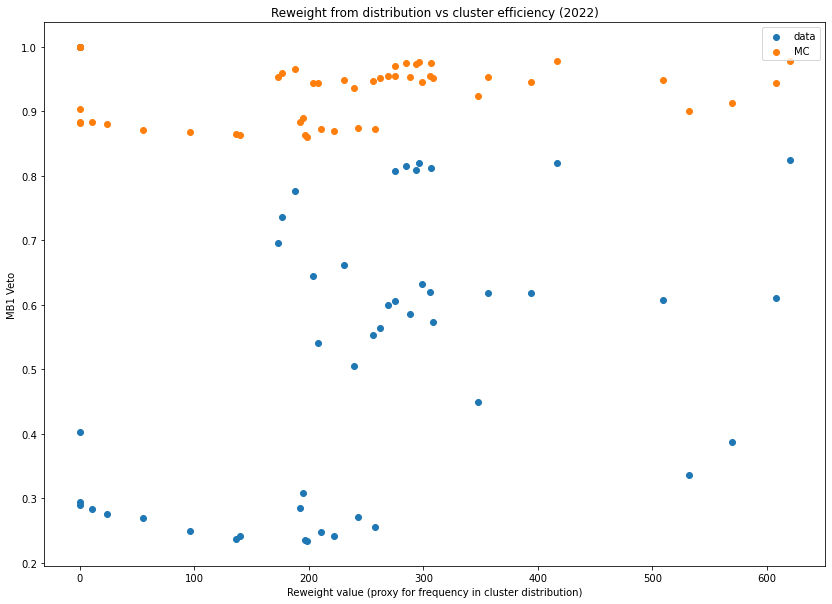

In [52]:
plt.figure(figsize=(14,10))
plt.scatter(weight_data, data_efficiencies, label="data")
plt.scatter(weight_MC, MC_efficiencies, label="MC")
plt.legend()
plt.title("Reweight from distribution vs cluster efficiency (2022)")
plt.ylabel("MB1 Veto")
plt.xlabel("Reweight value (proxy for frequency in cluster distribution)")